In [1]:
import sklearn.svm as sm
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import codecs

import re
import nltk
import nltk.stem.porter

In [2]:
# %load process_email.py
import re
import nltk
import nltk.stem.porter


def preProcess(email):
    
    hdrstart = email.find("\n\n")
    if hdrstart != -1:
        email = email[hdrstart:]

    email = email.lower()
    # Strip html tags. replace with a space
    email = re.sub('<[^<>]+>', ' ', email)
    # Any numbers get replaced with the string 'number'
    email = re.sub('[0-9]+', 'number', email)
    # Anything starting with http or https:// replaced with 'httpaddr'
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email)
    # Strings with "@" in the middle are considered emails --> 'emailaddr'
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email)
    # The '$' sign gets replaced with 'dollar'
    email = re.sub('[$]+', 'dollar', email)
    return email


def email2TokenList(raw_email):
    """
    Function that takes in a raw email, preprocesses it, tokenizes it,
    stems each word, and returns a list of tokens in the e-mail
    """

    stemmer = nltk.stem.porter.PorterStemmer()
    email = preProcess(raw_email)

    # Split the e-mail into individual words (tokens) 
    tokens = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]',
                      email)

    # Loop over each token and use a stemmer to shorten it
    tokenlist = []
    for token in tokens:

        token = re.sub('[^a-zA-Z0-9]', '', token)
        stemmed = stemmer.stem(token)
        #Throw out empty tokens
        if not len(token):
            continue
        # Store a list of all unique stemmed words
        tokenlist.append(stemmed)

    return tokenlist


In [3]:
# %load get_vocab_dict
def getVocabDict(reverse=False):
    """
    Function to read in the supplied vocab list text file into a dictionary.
    Dictionary key is the stemmed word, value is the index in the text file
    If "reverse", the keys and values are switched.
    """
    vocab_dict = {}
    with open("vocab.txt") as f:
        for line in f:
            (val, key) = line.split()
            if not reverse:
                vocab_dict[key] = int(val)
            else:
                vocab_dict[int(val)] = key

    return vocab_dict


In [4]:
def parte1():
    
    #Almacenamos los datos leídos en X, Y.
    data = loadmat('ex6data1.mat')
    X = data['X']
    Y = data['y'] 
    Y = Y.ravel()

    
    svm = sm.SVC(kernel='linear', C = 100)
    svm.fit(X,Y)
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)


    yp = svm.predict(np.array([x1.ravel(),x2.ravel()]).T).reshape(x1.shape)
    pos = (Y == 1).ravel()
    neg = (Y == 0).ravel()
  

    plt.figure()
    plt.scatter(X[pos, 0], X[pos, 1], color='black', marker='+')
    plt.scatter(X[neg, 0], X[neg, 1], color='yellow',
                edgecolors='black', marker='o')
    plt.contour(x1, x2, yp)

In [5]:
def parte2():
    
    #Almacenamos los datos leídos en X, Y.
    data = loadmat('ex6data2.mat')
    X = data['X']
    Y = data['y'] 
    Y = Y.ravel()
    sigma = 0.1
    
    svm = sm.SVC(kernel='rbf', C = 100, gamma = 1 / (2 * sigma**2))
    svm.fit(X,Y)
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)


    yp = svm.predict(np.array([x1.ravel(),x2.ravel()]).T).reshape(x1.shape)
    pos = (Y == 1).ravel()
    neg = (Y == 0).ravel()
  

    plt.figure()
    plt.scatter(X[pos, 0], X[pos, 1], color='black', marker='+')
    plt.scatter(X[neg, 0], X[neg, 1], color='yellow',
                edgecolors='black', marker='o')
    plt.contour(x1, x2, yp)

In [6]:
def parte3():
    
    #Almacenamos los datos leídos en X, Y.
    data = loadmat('ex6data3.mat')
    X = data['X']
    Y = data['y'] 
    Y = Y.ravel()
    
    Xval = data['Xval'] #Cargamos los ejemplos de validación
    Yval = data['yval'] 
  
    mayor = 0.0
    
    valores = [0.01,0.03,0.1,0.3,1,3,10,30]
    
    for i in range(len(valores)):
        for j in range(len(valores)):
            
            C = valores[i]
            sigma = valores[j]
            svm = sm.SVC(kernel='rbf', C = C, gamma = 1 / (2 * sigma**2))
            svm.fit(X,Y)
            Yval = Yval.ravel()
            res = sum((svm.predict(Xval) == Yval) *1)
            porcentaje = (res/Yval.shape[0])*100
            if porcentaje > mayor:
                mayor = porcentaje
                print("Porcentaje que clasifica correctamente sigma=", sigma, " C=", C, ":")
                print(porcentaje)
                print()

In [8]:
def parte4():
    
    spam = procesar_archivos("spam", 200)
    easy_ham = procesar_archivos("easy_ham", 100)
    hard_ham = procesar_archivos("hard_ham", 100)
    
    percnt_train = 0.7
    percnt_val = 0.3
    
    spam_train = spam[:int(50 *0.7)]
    easy_ham_train =easy_ham[:int(20 *0.7)]
    hard_ham_train =hard_ham[:int(20 *0.7)]
    
    spam_val = spam[int(50 *0.7):]
    easy_ham_val =easy_ham[int(20 *0.7):]
    hard_ham_val =hard_ham[int(20 *0.7):]

    print(spam_val.shape)
    print(easy_ham_val.shape)
    print(hard_ham_val.shape)
    
    X = np.concatenate((spam_train,easy_ham_train,hard_ham_train))
    Y = np.concatenate((np.ones((spam_train.shape[0],1)),
        np.zeros((easy_ham_train.shape[0],1)),np.zeros((hard_ham_train.shape[0],1))))
    
    Xval = np.concatenate((spam_val,easy_ham_val,hard_ham_val))
    Yval = np.concatenate((np.ones((spam_val.shape[0],1)),
        np.zeros((easy_ham_val.shape[0],1)),np.zeros((hard_ham_val.shape[0],1))))

    valores = [0.01,0.03,0.1,0.3,1,3,10,30]
    
    for i in range(len(valores)):
        for j in range(len(valores)):
            
            C = valores[i]
            sigma = valores[j]
            svm = sm.SVC(kernel='rbf', C = C, gamma = 1 / (2 * sigma**2))
            svm.fit(X,Y)
            Yval = Yval.ravel()
            res = sum((svm.predict(Xval) == Yval) *1)
            porcentaje = (res/Yval.shape[0])*100
            
            print("Porcentaje que clasifica correctamente sigma=", sigma, " C=", C, ":")
            print(porcentaje)
            print()


In [9]:
def procesar_email(directorio, num):
    
    email_contents = codecs.open('{0}/{1:04d}.txt'.format(directorio, num), 'r',encoding='utf-8', errors='ignore').read()
    email = email2TokenList(email_contents)
    vocab = getVocabDict()
    res = np.zeros((len(vocab)))

    
    for i in range(len(email)):
        
        if email[i] in vocab: 
            res[vocab[email[i]]-1] = 1 
       
        
    return res
        
def procesar_archivos(directorio, numFiles):
    
    matriz = []
    for i in range(numFiles):
        matriz.append(procesar_email(directorio, i+1))
    return np.array(matriz)

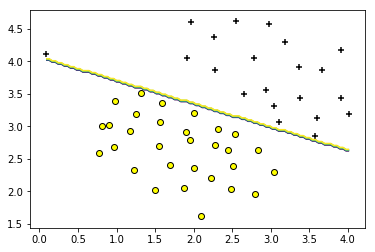

In [10]:
parte1()

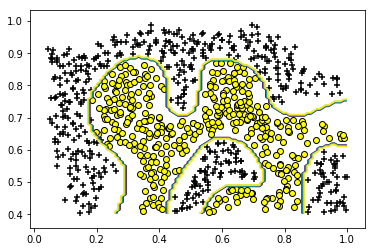

In [11]:
parte2()

In [12]:
parte3()

Porcentaje que clasifica correctamente sigma= 0.01  C= 0.01 :
43.5

Porcentaje que clasifica correctamente sigma= 0.1  C= 0.03 :
45.0

Porcentaje que clasifica correctamente sigma= 0.3  C= 0.03 :
86.0

Porcentaje que clasifica correctamente sigma= 0.1  C= 0.1 :
94.5

Porcentaje que clasifica correctamente sigma= 0.1  C= 0.3 :
96.0

Porcentaje que clasifica correctamente sigma= 0.1  C= 1 :
96.5



In [13]:
parte4()

(165, 1899)
(86, 1899)
(86, 1899)
Porcentaje que clasifica correctamente sigma= 0.01  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 0.03  C= 0.01 :
48.96142433234421



C:\Users\34697\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Porcentaje que clasifica correctamente sigma= 0.1  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 0.3  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 1  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 3  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 10  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 30  C= 0.01 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 0.01  C= 0.03 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 0.03  C= 0.03 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 0.1  C= 0.03 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 0.3  C= 0.03 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 1  C= 0.03 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 3  C= 0.03 :
48.96142433234421

Porcentaje que clasifica correctamente sigma= 10